In [1]:
from custom_clss_and_fncs import * 
import torch
import torch_geometric
from datetime import datetime
device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.init()
    if torch.cuda.is_initialized():
        device = 'cuda:0'
#device = torch.device(device)
print(f"{device = }")


loader_onlyC = torch.load("./results/dataloaders/loader_onlyC.pt")

/DeepenData/.miniconda/envs/geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device = 'cuda:0'


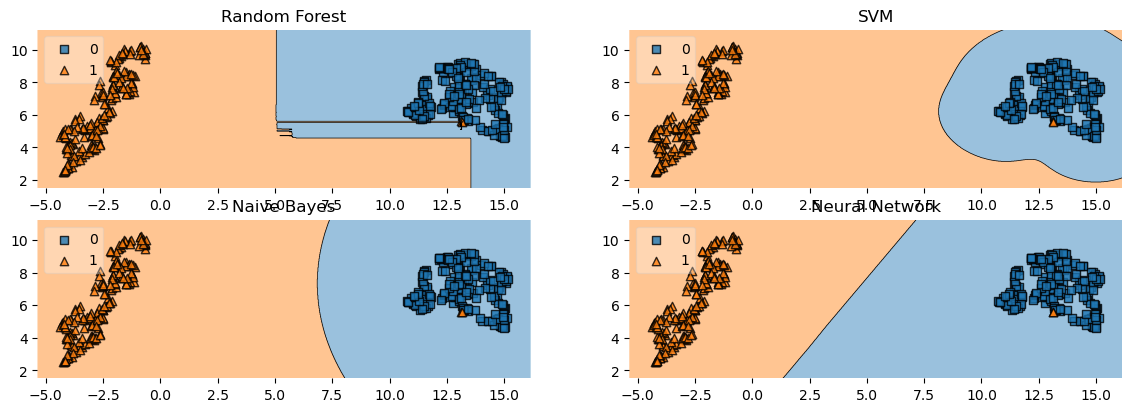

In [2]:
def plot_classsifiers(X, y):
    

    #clf1 = LogisticRegression()
    #clf2 = DecisionTreeClassifier()
    clf3 = RandomForestClassifier()
    clf4 = SVC(gamma='auto')
    clf5 = GaussianNB()
    clf6 = MLPClassifier()

    gs = gridspec.GridSpec(3, 2)
    fig = plt.figure(figsize=(14,7))
    labels = ['Random Forest', 'SVM', 'Naive Bayes', 'Neural Network']
    for clf, lab, grd in zip([clf3, clf4, clf5, clf6],
                            labels,
                            [(0,0), (0,1), (1,0), (1,1)]):
        clf.fit(X, y)
        ax = plt.subplot(gs[grd[0], grd[1]])
        fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
        plt.title(lab)
    plt.show()
    
    
    
def train_classifiers_with_dataloader(loader):   
    
    contatenated = torch.Tensor()
    labels_from_loader       = torch.Tensor()

    for data in loader:  # Iterate in batches over the training dataset.
            #data.to('cuda')
            #out = model(data.x, data.edge_index, data.batch)
            reshaped_batch     = data.x.reshape(data.y.shape[0], -1)
            contatenated       = torch.cat((contatenated,reshaped_batch),0)        
            labels_from_loader = torch.cat((labels_from_loader, data.y),0)
            

    non_zero_cols =  np.sum(contatenated.numpy() , 0) !=0
    X_from_loader = contatenated[:,non_zero_cols]

    reducer = umap.UMAP()
    embedding = reducer.fit_transform(X_from_loader)
    plot_classsifiers(embedding, labels_from_loader.to(int).numpy())
    plt.show()
train_classifiers_with_dataloader(loader_onlyC)

### Vanilla model

In [3]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GIN
from torch_geometric.nn import global_mean_pool
import torch

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        
        self.GIN_layers =  GIN(in_channels= 1, hidden_channels= hidden_channels, num_layers= 4, 
                               out_channels= hidden_channels, dropout=0.1,  jk=None, 
                               act='LeakyReLU', act_first = True)   
        
        #self.conv1 = GCNConv(1, hidden_channels)
        #self.conv2 = GCNConv(hidden_channels, hidden_channels)
        #self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2, bias=True)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        #x = self.conv1(x, edge_index)
        #x = x.relu()
        x = self.GIN_layers(x, edge_index)
        #x = F.dropout(x, p=0.1)
        x = x.relu()
        #x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        
        x = self.lin(x)
        
        return F.log_softmax(x, dim=1) #x
    
model    = GCN(hidden_channels=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()
loader = loader_onlyC
def train():
    model.to('cuda')
    model.train()

    for data in loader:  # Iterate in batches over the training dataset.
         data.to('cuda')
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()
     model.to('cuda')
     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data.to('cuda')
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 100):
    train()
    train_acc = test(loader)
    test_acc = test(loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.0226, Test Acc: 0.0283
Epoch: 002, Train Acc: 0.0298, Test Acc: 0.0304
Epoch: 003, Train Acc: 0.0475, Test Acc: 0.0460
Epoch: 004, Train Acc: 0.0429, Test Acc: 0.0444
Epoch: 005, Train Acc: 0.0462, Test Acc: 0.0445
Epoch: 006, Train Acc: 0.0324, Test Acc: 0.0328
Epoch: 007, Train Acc: 0.0288, Test Acc: 0.0265
Epoch: 008, Train Acc: 0.0450, Test Acc: 0.0477
Epoch: 009, Train Acc: 0.0481, Test Acc: 0.0471
Epoch: 010, Train Acc: 0.0243, Test Acc: 0.0255
Epoch: 011, Train Acc: 0.0328, Test Acc: 0.0305
Epoch: 012, Train Acc: 0.0400, Test Acc: 0.0413
Epoch: 013, Train Acc: 0.0293, Test Acc: 0.0276
Epoch: 014, Train Acc: 0.0236, Test Acc: 0.0250
Epoch: 015, Train Acc: 0.0446, Test Acc: 0.0445
Epoch: 016, Train Acc: 0.0415, Test Acc: 0.0379
Epoch: 017, Train Acc: 0.0309, Test Acc: 0.0343
Epoch: 018, Train Acc: 0.0423, Test Acc: 0.0429
Epoch: 019, Train Acc: 0.0460, Test Acc: 0.0470
Epoch: 020, Train Acc: 0.0452, Test Acc: 0.0428
Epoch: 021, Train Acc: 0.0466, Test Acc:

KeyboardInterrupt: 

In [4]:
#model
import torch.nn.functional as F
class GIN_classifier(torch.nn.Module):
    
    def __init__(
        self, 
        target_node_idx: int,
        n_nodes : int, 
        num_features : int, 
        out_channels: int = 8,
        dropout : float = 0.07, 
        hidden_dim : int = 8, 
        #heads : int = 5,
        LeakyReLU_slope : float = 0.01,

        num_layers: int = 4
    ):
        super(GIN_classifier, self).__init__() # TODO: why SUPER gato? 
        self.n_nodes = n_nodes
        self.dropout = dropout
        self.num_features = num_features
        self.target_node_idx = target_node_idx
        self.out_channels = out_channels
        
        self.GIN_layers =  GIN(in_channels= num_features, hidden_channels= hidden_dim, num_layers= num_layers, 
                               out_channels= out_channels, dropout=dropout,  jk=None, act='LeakyReLU', act_first = True)
        
        
        
               
        self.FC1        = Linear(in_features=out_channels, out_features=1, bias=True)
        self.FC2        = Linear(in_features=self.n_nodes, out_features=2, bias=True)
        
        
        
        
        
        #self.FC2        = Linear(in_features=n_nodes, out_features=1, bias=True)#.to('cuda')        #self.leakyrelu = LeakyReLU(LeakyReLU_slope).to('cuda')
        self.leakyrelu = LeakyReLU(LeakyReLU_slope)#.to('cuda')
    def forward(self, x):
        data       = x.x 
        edge_index = x.edge_index
        batch_size = x.y.shape[0]

        x     = self.GIN_layers(data, edge_index)
        x     = x.reshape(batch_size, self.n_nodes, self.out_channels)
        x     = self.FC1(self.leakyrelu(x))
        x     = x.reshape(batch_size,  self.n_nodes)              
        x     = self.FC2(self.leakyrelu(x))
        x     = x.reshape(batch_size, 2)
        
        
        
        return   F.log_softmax(x, dim=1).squeeze()#x.squeeze() #x[:,self.target_node_idx,:].squeeze()




a_batch         = next(iter(loader_onlyC))
a_graph         = a_batch[0]
model          = GIN_classifier(0, a_graph.num_nodes, a_graph.num_node_features)
out           = model(a_batch)
optimizer     = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.NLLLoss()
#loss_fun      = torch.nn.MSELoss()

loss_function(out, a_batch.y.long())


pred=out.argmax(dim=1) 
int((pred == a_batch.y).sum())/len(a_batch.y)




0.5390625

In [5]:
def train_one_epoch(modelo: GIN_classifier,
                    optimizer, 
                    train_loader: torch_geometric.loader.dataloader.DataLoader,
                    loss_fun: torch.nn.modules.loss,
                    scaler:torch.cuda.amp.grad_scaler.GradScaler,
                    swa_start:int,
                    swa_model,swa_scheduler,scheduler, 
                    n_batches_report:int, device:str='cpu' ):
    running_loss = 0.
    last_loss = 0.
    for i, data in enumerate(train_loader):
        assert not data.is_cuda   
        if (device == 'cuda:0') | (device == 'cuda'):                            
            data.to(device, non_blocking=True) 
            assert data.is_cuda
        
                
        optimizer.zero_grad(set_to_none=True) # Zero your gradients for every batch
        
        if (device == 'cuda:0') | (device == 'cuda'):
            with torch.cuda.amp.autocast():      
                predictions = modelo(data)# Make predictions for this batch
                loss        = loss_fun(predictions, data.y.long())
            scaler.scale(loss).backward()

            if (i+1) % 2 == 0:  
                if i > swa_start:
                    swa_model.update_parameters(modelo)
                    swa_scheduler.step()
                else:
                    scheduler.step()
            
            #check_seen_y.extend(data.y.squeeze().tolist())
            #loss.backward()  # Derive gradients.
                scaler.step(optimizer)
                scaler.update()
            #optimizer.step()  # Update parameters based on gradients.
                running_loss += loss.item()
                 
            
        else:
            with torch.cuda.amp.autocast():
                predictions = modelo(data)# Make predictions for this batch
                loss        = loss_fun(predictions, data.y.long())
            loss.backward()
            if (i+1) % 2 == 0:  
                if i > swa_start:
                    swa_model.update_parameters(modelo)
                    swa_scheduler.step()
                else:
                    scheduler.step()
                optimizer.step()
                running_loss += loss.item()   
            
        
    

            
        #It reports on the loss for every 100 batches.
        if i % n_batches_report == 99:
            last_loss = running_loss / n_batches_report
            running_loss = 0.
    torch.optim.swa_utils.update_bn(train_loader, swa_model, device=device)
    return last_loss

def validate(modelo: GIN_classifier, loss_fun: torch.nn, loader: DataLoader, device: str = 'cpu'):
    modelo.eval()
    running_vloss = 0.0
    correct = 0
    for i, val_data in enumerate(loader):
        
        assert not val_data.is_cuda
        if (device == 'cuda:0') | (device == 'cuda'):
            val_data.to(device, non_blocking=True) 
            assert val_data.is_cuda
                           
        #val_data.to(device, non_blocking=True) 

        val_predictions = modelo(val_data)# Make predictions for this batch
        pred            = val_predictions.argmax(dim=1)
        
        #val_loss    = loss_fun(predictions, val_data.y.long())
        #running_vloss += val_loss.item()
        correct += int((pred == val_data.y).sum())
        
    #avg_vloss = running_vloss / (i + 1)
    return correct / len(loader.dataset)   

from torch.optim.swa_utils import SWALR
import gc
import tqdm
gc.collect()
torch.cuda.empty_cache()  
  
#optimizer     = torch.optim.Adam(modelo.parameters(),)

def train_and_validate(modelo,loss_fun,optimizer, EPOCHS ,train_loader,validation_loader, 
                       validation_cycle:int = 4,
                       save_state_dict:bool = False,save_entire_model:bool = False,verbose:bool= False,
                       device:str='cpu', n_batches_report:int = 50, saving_path: str = '', tunning_mode:bool=False):
    
    modelo.to(device, non_blocking=True)
    scaler        = torch.cuda.amp.GradScaler()
    timestamp     = datetime.now().strftime('%d-%m-%Y_%Hh_%Mmin')    
    swa_model     = torch.optim.swa_utils.AveragedModel(modelo).to(device, non_blocking=True)    
    scheduler     = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
    swa_start     = 25
    swa_scheduler = SWALR(optimizer, swa_lr=0.05)
    epoch_number  = 0
    best_vloss    = 1e-10
    state_dict_path = None
    model_path      = None
    for epoch in tqdm.tqdm(range(EPOCHS)):

        modelo.train(True)
        avg_loss  = train_one_epoch(modelo, optimizer,train_loader, loss_fun, scaler, swa_start, swa_model, swa_scheduler, scheduler,
                                    n_batches_report = n_batches_report, device=device) 
        if epoch % validation_cycle == 0:
            avg_vloss = validate(modelo, loss_fun, validation_loader, device=device )                
        
        
        if avg_vloss > best_vloss:
            best_vloss            = avg_vloss
            best_val_state_dict   = copy.deepcopy(modelo.state_dict())
            best_val_model        = copy.deepcopy(modelo)
            if verbose:
                print(f"new best_val_model {best_vloss = }")
            
            
            if save_state_dict:
                state_dict_path = saving_path+'/state_dicts/State_Dict_{}_{}_best_vloss_{}_epoch_{}'.format(
                                                                modelo.__class__.__name__,timestamp, best_vloss, epoch_number)
                torch.save(modelo.state_dict(), state_dict_path)
                if verbose:
                    print(f"best state_dict saved as {state_dict_path}")
                    
            if save_entire_model:
                model_path = saving_path+'/models/Model_{}_{}_best_vloss_{}_epoch_{}.pt'.format(
                                                                modelo.__class__.__name__,timestamp, best_vloss, epoch_number)
                torch.save(best_val_model, model_path)
                if verbose:
                    print(f"best model saved as {model_path}")
                
                    
        epoch_number += 1
    #last_best_state_dict = copy.deepcopy(state_dict_path)
    if tunning_mode:
        return best_vloss
        
    return best_val_model, state_dict_path, model_path

In [9]:
model          = GIN_classifier(0, a_graph.num_nodes, a_graph.num_node_features)
optimizer     = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.NLLLoss()
best_val_model, last_best_state_dict_path, last_best_model_path =  train_and_validate(
                                    model,loss_function,optimizer, EPOCHS =500 ,
                                    train_loader= loader_onlyC,
                                    validation_loader= loader_onlyC,
                                    save_state_dict = False,save_entire_model=False,
                                    verbose=True,
                                    saving_path = 'results', device='cuda')


  0%|          | 1/500 [00:01<13:43,  1.65s/it]

new best_val_model best_vloss = 0.024696249339672478


  2%|▏         | 9/500 [00:13<12:06,  1.48s/it]

new best_val_model best_vloss = 0.025092445853143158


  3%|▎         | 13/500 [00:18<11:51,  1.46s/it]

new best_val_model best_vloss = 0.026148969889064975


  3%|▎         | 17/500 [00:24<11:22,  1.41s/it]

new best_val_model best_vloss = 0.047807712625462226


  4%|▍         | 21/500 [00:29<11:27,  1.43s/it]

new best_val_model best_vloss = 0.04833597464342314


  6%|▌         | 29/500 [00:41<11:32,  1.47s/it]

new best_val_model best_vloss = 0.048600105652403594


 12%|█▏        | 61/500 [01:27<10:47,  1.48s/it]

new best_val_model best_vloss = 0.04873217115689382


 19%|█▉        | 95/500 [02:18<09:52,  1.46s/it]


KeyboardInterrupt: 

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()


model    = GCN(hidden_channels=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()
loader = loader_onlyC
def train():
    model.to('cuda')
    model.train()

    for data in loader:  # Iterate in batches over the training dataset.
         data.to('cuda')
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y.long())  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()
     model.to('cuda')
     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data.to('cuda')
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y.long()).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 100):
    train()
    train_acc = test(loader)
    test_acc = test(loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.0226, Test Acc: 0.0283
Epoch: 002, Train Acc: 0.0298, Test Acc: 0.0304
Epoch: 003, Train Acc: 0.0471, Test Acc: 0.0453
Epoch: 004, Train Acc: 0.0413, Test Acc: 0.0429
Epoch: 005, Train Acc: 0.0461, Test Acc: 0.0441
Epoch: 006, Train Acc: 0.0309, Test Acc: 0.0308
Epoch: 007, Train Acc: 0.0288, Test Acc: 0.0265
Epoch: 008, Train Acc: 0.0465, Test Acc: 0.0481
Epoch: 009, Train Acc: 0.0475, Test Acc: 0.0470
Epoch: 010, Train Acc: 0.0231, Test Acc: 0.0251
Epoch: 011, Train Acc: 0.0363, Test Acc: 0.0335
Epoch: 012, Train Acc: 0.0449, Test Acc: 0.0465
Epoch: 013, Train Acc: 0.0309, Test Acc: 0.0293
Epoch: 014, Train Acc: 0.0239, Test Acc: 0.0259
Epoch: 015, Train Acc: 0.0318, Test Acc: 0.0316
Epoch: 016, Train Acc: 0.0301, Test Acc: 0.0289
Epoch: 017, Train Acc: 0.0477, Test Acc: 0.0481
Epoch: 018, Train Acc: 0.0395, Test Acc: 0.0398
Epoch: 019, Train Acc: 0.0310, Test Acc: 0.0281
Epoch: 020, Train Acc: 0.0479, Test Acc: 0.0478
Epoch: 021, Train Acc: 0.0475, Test Acc:

### END